## ERAD 2022 Open Source Workshop

### LROSE workflow - combining 3 NEXRAD radars, computing PID and Echo Type

<img align="right" width="400" height="400" src="./images/erad2022_cidd_mosaic.png">
    
The case we will use is from 2021/07/06 22:00 UTC, when a series of MCSs passed through the NW region of Kansas in the USA.

We will combine the reflectivity of 3 NEXRAD radars into a mini-mosaic:

- KGLD - Goodland, Kansas
- KUEX - Hastings, Nebraska
- KDDC - Dodge City, Kansas


We will download the following data sets from the cloud:

- raw NEXRAD files for KGLD, KUEX and KDDC, 2021/07/06 from 22:00 UTC to 22:30 UTC
- RUC model output for Kansas region, CF-NetCDF format, from 2021/07/06 at 23:00 UTC

The model data will provide a temperature profile for computing PID and Echo Type.

The workflow is as follows:

- download the data into ```/tmp/lrose_data/nexrad_mosaic```.
- run LROSE app RadxConvert, to convert raw NEXRAD files to CfRadial.
- plot an example PPI from KGLD using PyArt.
- read in temperature data from RUC file, plot cross sections using Matplotlib.
- run the LROSE app Mdv2SoundingSpdb to derive the temperature profile for each radar site from the RUC data file, and store in SPDB (a simple time-indexed data base).
- run the LROSE app RadxRate to compute precipition rate and Particle ID (PID).
- plot KDP, PID and precipitation rate for an example PPI.
- run the LROSE app Radx2Grid to convert the polar CfRadial files into Cartesian coordinates.
- run the LROSE app MdvMerge2 to merge the Cartesian files from the 3 radars into a reflectivity mini-mosaic.
- plot selected views of the reflectivity mosaic, using Matplotlib.
- run the LROSE app Ecco to compute the convective/stratiform partition using the reflectivity mosaic and the RUC temperature profile.
- plot the results of Ecco using Matplotlib.

We will use the following parameter files for the LROSE applications:

- params/RadxConvert.nexrad - convert raw NEXRAD files to CfRadial.
- params/Mdv2SoundingSpdb.ruc - create temperature profiles for each radar from RUC model temperature.
- params/RadxRate.nexrad - computes KDP, PID and precipition rate.
- params/kdp_params.nexrad - used by RadxRate to compute KDP.
- params/pid_params.nexrad - used by RadxRate to compute PID.
- params/pid_thresholds.nexrad - used by RadxRate to compute PID.
- params/rate_params.nexrad - used by RadxRate to compute precipitation rate.
- params/Ecco.nexrad_mosaic - used by Ecco to compute echo type classifications.

After the download step, the input files will be in:

```
  /tmp/lrose_data/nexrad_mosaic/raw/KGLD
  /tmp/lrose_data/nexrad_mosaic/raw/KUEX
  /tmp/lrose_data/nexrad_mosaic/raw/KDDC
  /tmp/lrose_data/nexrad_mosaic/mdv/ruc
```

The output files will be stored in:

```
  /tmp/lrose_data/nexrad_mosaic/cfradial (polar data)
  /tmp/lrose_data/nexrad_mosaic/mdv (Cartesian data)
  /tmp/lrose_data/nexrad_mosaic/spdb (temperature profile per radar)
```

### Initialize python

In [2]:
#
# Extra packages to be added to anaconda3 standard packages for this notebook:
#
#  conda update --all
#  conda install cartopy netCDF4
#  conda install -c conda-forge arm_pyart
#

import warnings
warnings.filterwarnings('ignore')

import os
import datetime
import pytz
import math
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy import feature as cfeature
import shapely
import netCDF4 as nc
import pyart

# Set data dir in environment variable
os.environ['NEXRAD_DATA_DIR'] = '/tmp/lrose_data/nexrad_mosaic'
nexradDataDir = os.environ['NEXRAD_DATA_DIR']
print('====>> nexradDataDir: ', nexradDataDir)

====>> nexradDataDir:  /tmp/lrose_data/nexrad_mosaic


### Download data sets from web

In [3]:
# Download input data sets
#
# 1. NEXRAD raw data files for KGLD, KDDC and KUEX
# 2. RUC model data for temperature profile, Kansas and surroundings
#
# These will be put in:
#  ${NEXRAD_DATA_DIR}
#

# ensure the data dir exists and is clean

!/bin/rm -rf ${NEXRAD_DATA_DIR}
!mkdir -p ${NEXRAD_DATA_DIR}

# download the data from github

print("====>> Downloading data tar files into dir: ", nexradDataDir)

!cd ${NEXRAD_DATA_DIR}; wget http://front.eol.ucar.edu/data/notebooks/nexrad_mosaic/nexrad_mosaic.KGLD.20210706_220000.tgz 
!cd ${NEXRAD_DATA_DIR}; wget http://front.eol.ucar.edu/data/notebooks/nexrad_mosaic/nexrad_mosaic.KDDC.20210706_220000.tgz 
!cd ${NEXRAD_DATA_DIR}; wget http://front.eol.ucar.edu/data/notebooks/nexrad_mosaic/nexrad_mosaic.KUEX.20210706_220000.tgz 
!cd ${NEXRAD_DATA_DIR}; wget http://front.eol.ucar.edu/data/notebooks/nexrad_mosaic/nexrad_mosaic.ruc.20210706_220000.tgz 
 
# !cd ${NEXRAD_DATA_DIR}; wget https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/nexrad_mosaic/nexrad_mosaic.ruc.20210706_220000.tgz
# !cd ${NEXRAD_DATA_DIR}; wget https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/nexrad_mosaic/nexrad_mosaic.KGLD.20210706_220000.tgz
# !cd ${NEXRAD_DATA_DIR}; wget https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/nexrad_mosaic/nexrad_mosaic.KDDC.20210706_220000.tgz
# !cd ${NEXRAD_DATA_DIR}; wget https://raw.githubusercontent.com/NCAR/lrose-data-examples/master/notebooks/nexrad_mosaic/nexrad_mosaic.KUEX.20210706_220000.tgz

# extract the data from the tar files

print("====>> The following data files are unpacked in dir: ", nexradDataDir)
!cd ${NEXRAD_DATA_DIR}; tar xvfz nexrad_mosaic.ruc.20210706_220000.tgz
!cd ${NEXRAD_DATA_DIR}; tar xvfz nexrad_mosaic.KGLD.20210706_220000.tgz
!cd ${NEXRAD_DATA_DIR}; tar xvfz nexrad_mosaic.KDDC.20210706_220000.tgz
!cd ${NEXRAD_DATA_DIR}; tar xvfz nexrad_mosaic.KUEX.20210706_220000.tgz

# clean up

!cd ${NEXRAD_DATA_DIR}; /bin/rm -f *tgz


====>> Downloading data tar files into dir:  /tmp/lrose_data/nexrad_mosaic
--2022-08-23 17:16:34--  http://front.eol.ucar.edu/data/notebooks/nexrad_mosaic/nexrad_mosaic.KGLD.20210706_220000.tgz
Resolving front.eol.ucar.edu (front.eol.ucar.edu)... 128.117.43.125
Connecting to front.eol.ucar.edu (front.eol.ucar.edu)|128.117.43.125|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74762580 (71M) [application/x-gzip]
Saving to: 'nexrad_mosaic.KGLD.20210706_220000.tgz'

nexrad_mosaic.KGLD. 100%[===================>]  71.30M   111MB/s    in 0.6s    

2022-08-23 17:16:35 (111 MB/s) - 'nexrad_mosaic.KGLD.20210706_220000.tgz' saved [74762580/74762580]

--2022-08-23 17:16:35--  http://front.eol.ucar.edu/data/notebooks/nexrad_mosaic/nexrad_mosaic.KDDC.20210706_220000.tgz
Resolving front.eol.ucar.edu (front.eol.ucar.edu)... 128.117.43.125
Connecting to front.eol.ucar.edu (front.eol.ucar.edu)|128.117.43.125|:80... connected.
HTTP request sent, awaiting response... 200 OK
Leng

## Notes on LROSE Parameter files

All LROSE applications have a detailed parameter file, which is read in at startup.

The parameters allow the user to control the processing in the LROSE apps.

To generate a default parameter file, you use the -print_params option for the app.

For example, for RadxConvert you would use:

```
  RadxConvert -print_params > RadxConvert.nexrad
```

and then edit RadxConvert.nexrad appropriately.

At runtime you would use:

```
  RadxConvert -params RadxConvert.nexrad ... etc ...
```

## View the RadxConvert parameter file

Note that we can use environment variables in the parameter files.

Environment variables are inserted using the format:

```
  $(env_var_name)
```

For example:

```
  input_dir = "$(NEXRAD_DATA_DIR)/raw/$(RADAR_NAME)";
```


In [4]:
# View the param file
!cat ./params/RadxConvert.nexrad

/**********************************************************************
 * TDRP params for RadxConvert
 **********************************************************************/

//======================================================================
//
// Converts files between CfRadial and other radial formats.
//
//======================================================================
 
//======================================================================
//
// DEBUGGING.
//
//======================================================================
 
///////////// debug ///////////////////////////////////
//
// Debug option.
// If set, debug messages will be printed appropriately.
//
// Type: enum
// Options:
//     DEBUG_OFF
//     DEBUG_NORM
//     DEBUG_VERBOSE
//     DEBUG_EXTRA
//

debug = DEBUG_OFF;

///////////// instance ////////////////////////////////
//
// Program instance for process registration.
// This application registers with procmap. This is the instance used 
// 

## Convert raw nexrad files to CfRadial format

In [6]:
# Convert raw nexrad data to cfradial for 3 NEXRAD radars

for radar_name in ['KGLD', 'KUEX', 'KDDC']:
    # Set radar in name environment variable
    os.environ['RADAR_NAME'] = radar_name
    # Run RadxConvert using param file
    !/usr/local/lrose/bin/RadxConvert -params ./params/RadxConvert.nexrad -debug -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00"


Program 'RadxConvert'
Run-time 2022/08/23 23:18:17.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to 

INFO - RadxConvert::Run
  Input path: /tmp/lrose_data/nexrad_mosaic/raw/KGLD/20210706/KGLD20210706_222350_V06
WARNING - NexradRadxFile::readFromPath
  Adaptation data probably not set, ignoring
  File: /tmp/lrose_data/nexrad_mosaic/raw/KGLD/20210706/KGLD20210706_222350_V06
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KGLD
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KGLD
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KGLD/20210706/cfrad.20210706_222350.154_to_20210706_222826.584_KGLD_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KGLD/20210706/tmp.20569.1661296715.451022.tmp
  Writing fields and compressing ...
  ... writing field: DBZ
  ... writing field: VEL
  ... writing field: WIDTH
  ... writing field: ZDR
  ... writing field: PHIDP
  ... writing field: RHOHV
DEBUG - NcfRadxFile::writeToPath
  Ren

INFO - RadxConvert::Run
  Input path: /tmp/lrose_data/nexrad_mosaic/raw/KUEX/20210706/KUEX20210706_221633_V06
WARNING - NexradRadxFile::readFromPath
  Adaptation data probably not set, ignoring
  File: /tmp/lrose_data/nexrad_mosaic/raw/KUEX/20210706/KUEX20210706_221633_V06
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KUEX
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KUEX
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KUEX/20210706/cfrad.20210706_221633.850_to_20210706_222054.868_KUEX_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KUEX/20210706/tmp.20588.1661296730.935994.tmp
  Writing fields and compressing ...
  ... writing field: DBZ
  ... writing field: VEL
  ... writing field: WIDTH
  ... writing field: ZDR
  ... writing field: PHIDP
  ... writing field: RHOHV
DEBUG - NcfRadxFile::writeToPath
  Ren

INFO - RadxConvert::Run
  Input path: /tmp/lrose_data/nexrad_mosaic/raw/KDDC/20210706/KDDC20210706_220921_V06
WARNING - NexradRadxFile::readFromPath
  Adaptation data probably not set, ignoring
  File: /tmp/lrose_data/nexrad_mosaic/raw/KDDC/20210706/KDDC20210706_220921_V06
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KDDC
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KDDC
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KDDC/20210706/cfrad.20210706_220921.610_to_20210706_221350.957_KDDC_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KDDC/20210706/tmp.20608.1661296747.410519.tmp
  Writing fields and compressing ...
  ... writing field: DBZ
  ... writing field: VEL
  ... writing field: WIDTH
  ... writing field: ZDR
  ... writing field: PHIDP
  ... writing field: RHOHV
DEBUG - NcfRadxFile::writeToPath
  Ren

## List the CfRadial files created by RadxConvert

In [7]:
# List the CfRadial files created by RadxConvert
!ls -R ${NEXRAD_DATA_DIR}/cfradial/moments/K*/20*

/tmp/lrose_data/nexrad_mosaic/cfradial/moments/KDDC/20210706:
cfrad.20210706_220000.765_to_20210706_220422.888_KDDC_SUR.nc
cfrad.20210706_220430.757_to_20210706_220912.758_KDDC_SUR.nc
cfrad.20210706_220921.610_to_20210706_221350.957_KDDC_SUR.nc
cfrad.20210706_221600.999_to_20210706_222043.450_KDDC_SUR.nc
cfrad.20210706_222051.218_to_20210706_222526.565_KDDC_SUR.nc
cfrad.20210706_222533.934_to_20210706_223025.212_KDDC_SUR.nc

/tmp/lrose_data/nexrad_mosaic/cfradial/moments/KGLD/20210706:
cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc
cfrad.20210706_220448.793_to_20210706_220926.383_KGLD_SUR.nc
cfrad.20210706_220935.631_to_20210706_221411.627_KGLD_SUR.nc
cfrad.20210706_221420.555_to_20210706_221857.324_KGLD_SUR.nc
cfrad.20210706_221906.199_to_20210706_222341.850_KGLD_SUR.nc
cfrad.20210706_222350.154_to_20210706_222826.584_KGLD_SUR.nc
cfrad.20210706_222834.963_to_20210706_223310.845_KGLD_SUR.nc

/tmp/lrose_data/nexrad_mosaic/cfradial/moments/KUEX/20210706:
cfrad.20210706_2202

## Plot one example of the NEXRAD Goodland radar (KGLD) CfRadial files

In [8]:
# Read CfRadial file into radar object
filePathRadar = os.path.join(nexradDataDir, "cfradial/moments/KGLD/20210706/cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc")
radar_kgld = pyart.io.read_cfradial(filePathRadar)
radar_kgld.info('compact')

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: <ndarray of type: float64 and shape: (1,)>
antenna_transition: <ndarray of type: int8 and shape: (6120,)>
azimuth: <ndarray of type: float32 and shape: (6120,)>
elevation: <ndarray of type: float32 and shape: (6120,)>
fields:
	DBZ: <ndarray of type: float32 and shape: (6120, 912)>
	VEL: <ndarray of type: float32 and shape: (6120, 912)>
	WIDTH: <ndarray of type: float32 and shape: (6120, 912)>
	ZDR: <ndarray of type: float32 and shape: (6120, 912)>
	PHIDP: <ndarray of type: float32 and shape: (6120, 912)>
	RHOHV: <ndarray of type: float32 and shape: (6120, 912)>
fixed_angle: <ndarray of type: float32 and shape: (14,)>
instrument_parameters:
	follow_mode: <ndarray of type: |S1 and shape: (14, 32)>
	pulse_width: <ndarray of type: float32 and shape: (6120,)>
	prt_mode: <ndarray of type: |S1 and shape: (14, 32)>
	prt: <ndarray of type: float32 and shape: (6120,)>
	prt_ratio: <ndarray of type: float32 and shape: (6120,)>
	pol

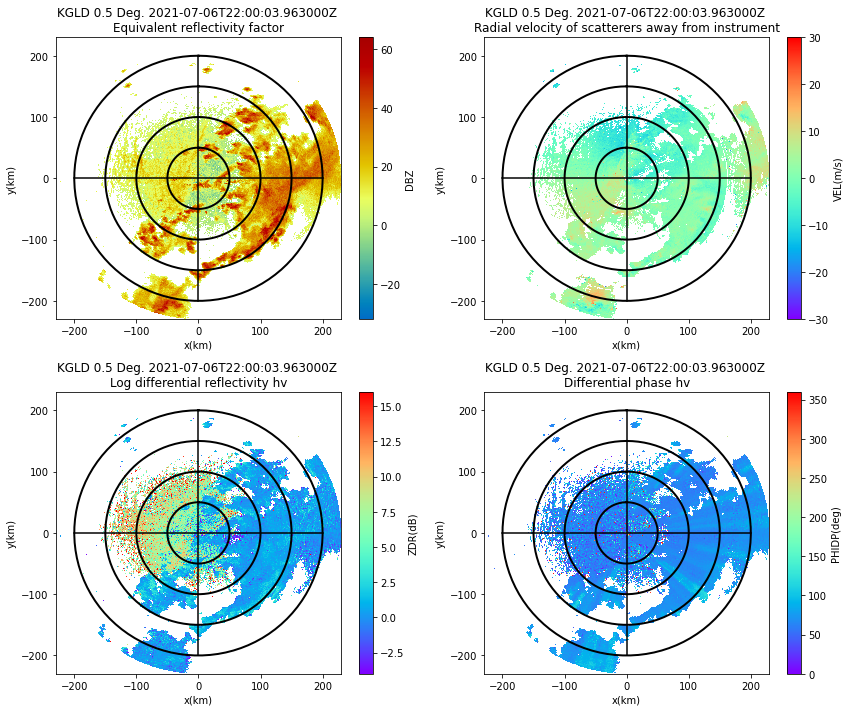

In [9]:
# Plot KGLD fields from this CfRadial file

displayKgld = pyart.graph.RadarDisplay(radar_kgld)
figKgld = plt.figure(1, (12, 10))

# DBZ

axDbz = figKgld.add_subplot(221)
displayKgld.plot_ppi('DBZ', 0, vmin=-32, vmax=64.,
                    axislabels=("x(km)", "y(km)"),
                    colorbar_label="DBZ")
displayKgld.plot_range_rings([50, 100, 150, 200])
displayKgld.plot_cross_hair(200.)

# VEL

axVel = figKgld.add_subplot(222)
displayKgld.plot_ppi('VEL', 0, vmin=-30, vmax=30.,
                    axislabels=("x(km)", "y(km)"),
                    colorbar_label="VEL(m/s)",
                    cmap = "rainbow")
displayKgld.plot_range_rings([50, 100, 150, 200])
displayKgld.plot_cross_hair(200.)

# ZDR

axZdr = figKgld.add_subplot(223)
displayKgld.plot_ppi('ZDR', 0, vmin=-4, vmax=16.,
                    axislabels=("x(km)", "y(km)"),
                    colorbar_label="ZDR(dB)",
                    cmap = "rainbow")
displayKgld.plot_range_rings([50, 100, 150, 200])
displayKgld.plot_cross_hair(200.)

# PHIDP

axPhidp = figKgld.add_subplot(224)
displayKgld.plot_ppi('PHIDP', 0,
                    axislabels=("x(km)", "y(km)"),
                    colorbar_label="PHIDP(deg)",
                    cmap = "rainbow")
displayKgld.plot_range_rings([50, 100, 150, 200])
displayKgld.plot_cross_hair(200.)

# set layout and display

figKgld.tight_layout()
plt.show()


### Read in temperature field from RUC model, to provide temperature profile for PID and Ecco

In [10]:
filePathModel = os.path.join(nexradDataDir, 'mdv/ruc/20210706/20210706_230000.mdv.cf.nc')
dsModel = nc.Dataset(filePathModel)
print(dsModel)
dstemp = dsModel['TMP']
temp3D = np.array(dstemp)
fillValueTemp = dstemp._FillValue
if (len(temp3D.shape) == 4):
    temp3D = temp3D[0]

# Compute time

uTimeSecsModel = dsModel['start_time'][0]
startTimeModel = datetime.datetime.fromtimestamp(int(uTimeSecsModel))
startTimeStrModel = startTimeModel.strftime('%Y/%m/%d-%H:%M:%S UTC')
print("Start time model: ", startTimeStrModel)

# Compute Model grid limits
(nZModel, nYModel, nXModel) = temp3D.shape
lon = np.array(dsModel['x0'])
lat = np.array(dsModel['y0'])
ht = np.array(dsModel['z0'])
dLonModel = lon[1] - lon[0]
dLatModel = lat[1] - lat[0]
minLonModel = lon[0] - dLonModel / 2.0
maxLonModel = lon[-1] + dLonModel / 2.0
minLatModel = lat[0] - dLatModel / 2.0
maxLatModel = lat[-1] + dLatModel / 2.0
minHtModel = ht[0]
maxHtModel = ht[-1]
print("nZModel, nYModel, nXModel", nZModel, nYModel, nXModel)
print("minLonModel, maxLonModel: ", minLonModel, maxLonModel)
print("minLatModel, maxLatModel: ", minLatModel, maxLatModel)
print("minHt, maxHt: ", minHtModel, maxHtModel)
print("Model hts: ", ht)
del lon, lat, ht

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: Converted from NetCDF to MDV, 2022/08/21 03:33:17
  Ncf:comment: 

    source: Grib2
    title: RUC Rapid Refresh
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(139), y0(72), z0(32), nbytes_mdv_chunk_0000(174)
    variables(dimensions): float64 time(time), float64 forecast_reference_time(time), float64 forecast_period(time), float64 start_time(time), float64 stop_time(time), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), int8 mdv_chunk_0000(time, nbytes_mdv_chunk_0000), float32 TMP(time, z0, y0, x0), float32 RH(time, z0, y0, x0), float32 UGRD(time, z0, y0, x0), float32 VGRD(time, z0, y0, x0), float32 VVEL(time, z0, y0, x0), float32 HGT(time, z0, y0, x0), float32 Pressure(time, z0, y0, x0)
    groups: 
Start time model:  2021/07/06-17:00:00 UTC
nZModel, nYModel, nXModel 32 72 139
minLonModel, maxLo

## Plot W-E and N-S vertical sections of temperature data

In [11]:
# Compute Temp N-S vertical section
nXHalfModel = int(nXModel/2)
tempVertNS = temp3D[:, :, nXHalfModel:(nXHalfModel+1)]
tempVertNS = tempVertNS.reshape(tempVertNS.shape[0], tempVertNS.shape[1])
tempVertNS[tempVertNS == fillValueTemp] = np.nan
print(tempVertNS.shape)
tempNSMax = np.amax(temp3D, (2))
tempNSMax[tempNSMax == fillValueTemp] = np.nan

# Compute Temp W-E vertical section
nYHalfModel = int(nYModel/2)
tempVertWE = temp3D[:, nYHalfModel:(nYHalfModel+1), :]
print(tempVertWE.shape)
tempVertWE = tempVertWE.reshape(tempVertWE.shape[0], tempVertWE.shape[2])
tempVertWE[tempVertWE == fillValueTemp] = np.nan
tempWEMax = np.amax(temp3D, (1))
tempWEMax[tempWEMax == fillValueTemp] = np.nan
print(tempVertWE.shape)

(32, 72)
(32, 1, 139)
(32, 139)


Text(0.5, 1.0, 'Vert slice mid N-S temp: 2021/07/06-17:00:00 UTC')

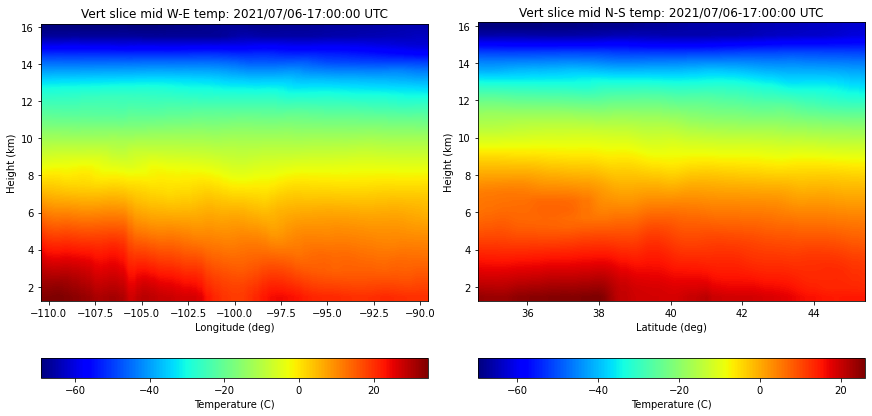

In [12]:
# Plot model temp vertical sections at mid-points of grid

figModelTemp = plt.figure(num=1, figsize=[12, 8], layout='constrained')

# Plot W-E temp

axWETemp = figModelTemp.add_subplot(1, 2, 1,
                                    xlim = (minLonModel, maxLonModel),
                                    ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertWE,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonModel, maxLonModel, minHtModel, maxHtModel))
axWETemp.set_aspect(1.0)
axWETemp.set_xlabel('Longitude (deg)')
axWETemp.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid W-E temp: " + startTimeStrModel)

# Plot N-S temp vertical section

axNSTemp = figModelTemp.add_subplot(1, 2, 2, 
                                    xlim = (minLatModel, maxLatModel),
                                    ylim = (minHtModel, maxHtModel))
plt.imshow(tempVertNS,
    cmap='jet',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatModel, maxLatModel, minHtModel, maxHtModel))
axNSTemp.set_aspect(0.52)
axNSTemp.set_xlabel('Latitude (deg)')
axNSTemp.set_ylabel('Height (km)')
plt.colorbar(label="Temperature (C)", orientation="horizontal", fraction=0.1)
plt.title("Vert slice mid N-S temp: " + startTimeStrModel)


## Sample RUC temperatures at 3 radar locations, save in SPDB data base

In [13]:
# Run Mdv2SoundingSpdb to sample temperature data and store in SPDB
!/usr/local/lrose/bin/Mdv2SoundingSpdb -debug -params params/Mdv2SoundingSpdb.ruc -start "2021 07 06 00 00 00" -end "2021 07 07 00 00 00"

Program 'Mdv2SoundingSpdb'
Run-time 2022/08/23 23:19:48.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as no

Ncf2MdvTrans::_shouldAddField
  -->> adding field: RH
Ncf2MdvTrans::_shouldAddField
  Checking variable for field data: RH
SUCCESS - var has X coordinate, dim: x0
SUCCESS - var has Y coordinate, dim: y0
NOTE - var has Z coordinate, dim: z0
Ncf2MdvTrans::_addOneField
  -->> adding field: RH
Adding data field: RH
             time: 2021/07/06 23:00:00
Ncf2MdvTrans::_shouldAddField
  -->> adding field: UGRD
Ncf2MdvTrans::_shouldAddField
  Checking variable for field data: UGRD
SUCCESS - var has X coordinate, dim: x0
SUCCESS - var has Y coordinate, dim: y0
NOTE - var has Z coordinate, dim: z0
Ncf2MdvTrans::_addOneField
  -->> adding field: UGRD
Adding data field: UGRD
             time: 2021/07/06 23:00:00
Ncf2MdvTrans::_shouldAddField
  -->> adding field: VGRD
Ncf2MdvTrans::_shouldAddField
  Checking variable for field data: VGRD
SUCCESS - var has X coordinate, dim: x0
SUCCESS - var has Y coordinate, dim: y0
NOTE - var has Z coordinate, dim: z0
Ncf2MdvTrans::_addOneField
  -->> adding fie

## List sounding data base

In [14]:
# List SPDB files
!ls -alR /tmp/lrose_data/nexrad_mosaic/spdb/sounding/ruc/20210706*

-rw-rw-r-- 1 mdtest mdtest 4704 Aug 23 17:19 /tmp/lrose_data/nexrad_mosaic/spdb/sounding/ruc/20210706.data
-rw-rw-r-- 1 mdtest mdtest 6360 Aug 23 17:19 /tmp/lrose_data/nexrad_mosaic/spdb/sounding/ruc/20210706.indx


## Run RadxRate on the CfRadial files

RadxRate will compute:

* KDP - specific differential phase
* KDP_SC - KDP conditioned using Z and ZDR self-consistency
* PID - NCAR Particle ID (type)
* RATE_ZH - precip rate from standard ZR relationship
* RATE_HYBRID - precip rate from NCAR hybrid estimator

RadxRate has a main parameter file, which then specifies a parameter file computing each of KDP, PID and precip rate.

The PID step requires an additional parameter file specifying the fuzzy logic thresholds.

The parameter files used here are:

* kdp_params.nexrad
* pid_params.nexrad
* pid_thresholds.nexrad
* rate_params.nexrad

In [15]:
# Run RadxRate for 3 NEXRAD radars

for radar_name in ['KGLD', 'KUEX', 'KDDC']:
    # Set radar in name environment variable
    os.environ['RADAR_NAME'] = radar_name
    # Run RadxRate using param file
    !/usr/local/lrose/bin/RadxRate -params ./params/RadxRate.nexrad -debug -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00"

RadxRate::_runArchive
  Input dir: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KGLD
  Start time: 2021/07/06 22:00:00
  End time: 2021/07/06 22:30:00
INFO - RadxRate::Run
  Input path: /tmp/lrose_data/nexrad_mosaic/cfradial/moments/KGLD/20210706/cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc
Thread #: 0
  Loading temp profile for time: 2021/07/06 22:00:03
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD/20210706/cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD/20210706/tmp.20812.1661296815.701177.tmp
  Writing fields and compressing ...
  ... writing field: RATE_ZH
  ... writing field: RATE_HYBRID
  ... writing field: PID
  ... writing fiel

Thread #: 0
  Loading temp profile for time: 2021/07/06 22:28:34
INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD/20210706/cfrad.20210706_222834.963_to_20210706_223310.845_KGLD_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD/20210706/tmp.20812.1661296835.977260.tmp
  Writing fields and compressing ...
  ... writing field: RATE_ZH
  ... writing field: RATE_HYBRID
  ... writing field: PID
  ... writing field: KDP
  ... writing field: DBZ
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD/20210706/tmp.20812.1661296835.977260.tmp
     to final path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD/20210706/cfrad.20210706_222834.963_to_20210706_223310.845_KGLD_SUR

INFO: RadxFile::writeToDir
  Writing CfRadial file to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KUEX
DEBUG - NcfRadxFile::writeToDir
  Writing to dir: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KUEX
DEBUG - NcfRadxFile::writeToPath
  Writing to path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KUEX/20210706/cfrad.20210706_222531.244_to_20210706_222952.818_KUEX_SUR.nc
  Tmp path is: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KUEX/20210706/tmp.20839.1661296857.317240.tmp
  Writing fields and compressing ...
  ... writing field: RATE_ZH
  ... writing field: RATE_HYBRID
  ... writing field: PID
  ... writing field: KDP
  ... writing field: DBZ
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KUEX/20210706/tmp.20839.1661296857.317240.tmp
     to final path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KUEX/20210706/cfrad.20210706_222531.244_to_20210706_222952.818_KUEX_SUR.nc
INFO: RadxFile::writeToDir
  Wrote CfRadial file to path: /tm

  ... writing field: RATE_ZH
  ... writing field: RATE_HYBRID
  ... writing field: PID
  ... writing field: KDP
  ... writing field: DBZ
DEBUG - NcfRadxFile::writeToPath
  Renamed tmp path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KDDC/20210706/tmp.20871.1661296878.543055.tmp
     to final path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KDDC/20210706/cfrad.20210706_222533.934_to_20210706_223025.212_KDDC_SUR.nc
INFO: RadxFile::writeToDir
  Wrote CfRadial file to path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KDDC/20210706/cfrad.20210706_222533.934_to_20210706_223025.212_KDDC_SUR.nc


## List files created by RadxRate

In [16]:
# List the CfRadial files created by RadxRate
!ls -R ${NEXRAD_DATA_DIR}/cfradial/rate/K*/2*

/tmp/lrose_data/nexrad_mosaic/cfradial/rate/KDDC/20210706:
cfrad.20210706_220000.765_to_20210706_220422.888_KDDC_SUR.nc
cfrad.20210706_220430.757_to_20210706_220912.758_KDDC_SUR.nc
cfrad.20210706_220921.610_to_20210706_221350.957_KDDC_SUR.nc
cfrad.20210706_221600.999_to_20210706_222043.450_KDDC_SUR.nc
cfrad.20210706_222051.218_to_20210706_222526.565_KDDC_SUR.nc
cfrad.20210706_222533.934_to_20210706_223025.212_KDDC_SUR.nc

/tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD/20210706:
cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc
cfrad.20210706_220448.793_to_20210706_220926.383_KGLD_SUR.nc
cfrad.20210706_220935.631_to_20210706_221411.627_KGLD_SUR.nc
cfrad.20210706_221420.555_to_20210706_221857.324_KGLD_SUR.nc
cfrad.20210706_221906.199_to_20210706_222341.850_KGLD_SUR.nc
cfrad.20210706_222350.154_to_20210706_222826.584_KGLD_SUR.nc
cfrad.20210706_222834.963_to_20210706_223310.845_KGLD_SUR.nc

/tmp/lrose_data/nexrad_mosaic/cfradial/rate/KUEX/20210706:
cfrad.20210706_220249.032_to

## Plot PID and rate results for NEXRAD Goodland radar (KGLD)

In [17]:
# Read CfRadial file into radar object
filePathRate = os.path.join(nexradDataDir, "cfradial/rate/KGLD/20210706/cfrad.20210706_220003.963_to_20210706_220439.770_KGLD_SUR.nc")
rate_kgld = pyart.io.read_cfradial(filePathRate)
rate_kgld.info('compact')

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: <ndarray of type: float64 and shape: (1,)>
antenna_transition: <ndarray of type: int8 and shape: (6120,)>
azimuth: <ndarray of type: float32 and shape: (6120,)>
elevation: <ndarray of type: float32 and shape: (6120,)>
fields:
	RATE_ZH: <ndarray of type: float32 and shape: (6120, 912)>
	RATE_HYBRID: <ndarray of type: float32 and shape: (6120, 912)>
	PID: <ndarray of type: float32 and shape: (6120, 912)>
	KDP: <ndarray of type: float32 and shape: (6120, 912)>
	DBZ: <ndarray of type: float32 and shape: (6120, 912)>
fixed_angle: <ndarray of type: float32 and shape: (14,)>
instrument_parameters:
	follow_mode: <ndarray of type: |S1 and shape: (14, 32)>
	pulse_width: <ndarray of type: float32 and shape: (6120,)>
	prt_mode: <ndarray of type: |S1 and shape: (14, 32)>
	prt: <ndarray of type: float32 and shape: (6120,)>
	prt_ratio: <ndarray of type: float32 and shape: (6120,)>
	polarization_mode: <ndarray of type: |S1 and shape: (

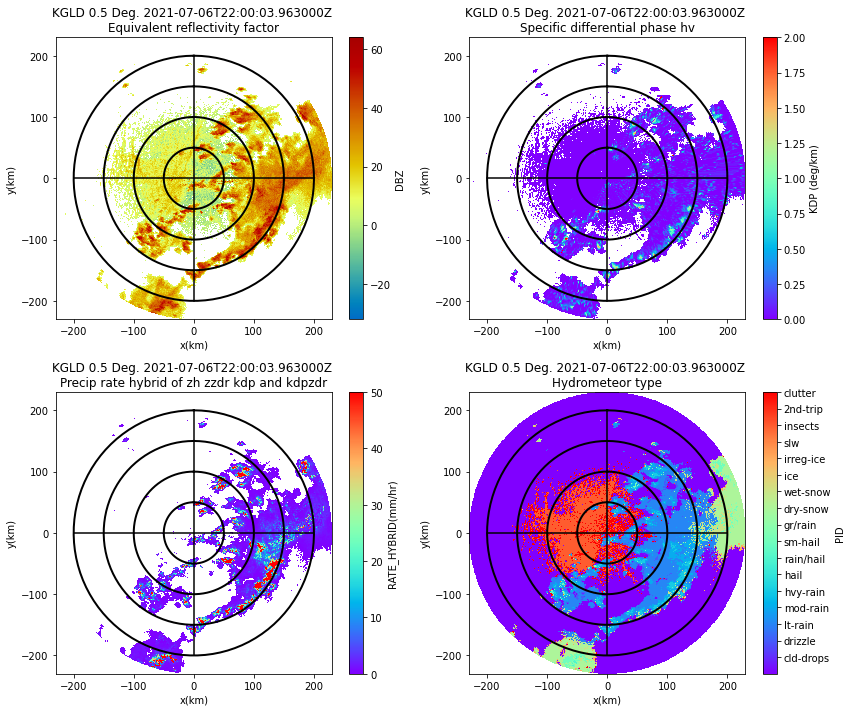

In [18]:
# Plot results of RadxRate

displayRate = pyart.graph.RadarDisplay(rate_kgld)
figRate = plt.figure(1, (12, 10))

# DBZ (input)

axDbz = figRate.add_subplot(221)
displayRate.plot_ppi('DBZ', 0, vmin=-32, vmax=64.,
                    axislabels=("x(km)", "y(km)"),
                    colorbar_label="DBZ")
displayRate.plot_range_rings([50, 100, 150, 200])
displayRate.plot_cross_hair(200.)

# KDP (computed)

axKdp = figRate.add_subplot(222)
displayRate.plot_ppi('KDP', 0, vmin=0, vmax=2.,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="KDP (deg/km)",
    cmap="rainbow")
displayRate.plot_range_rings([50, 100, 150, 200])
displayRate.plot_cross_hair(200.)

# RATE_HYBRID (computed)

axHybrid = figRate.add_subplot(223)
displayRate.plot_ppi('RATE_HYBRID', 0, vmin=0, vmax=50.,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="RATE_HYBRID(mm/hr)",
    cmap = "rainbow")
displayRate.plot_range_rings([50, 100, 150, 200])
displayRate.plot_cross_hair(200.)

# NCAR PID (computed)

axPID = figRate.add_subplot(224)
displayRate.plot_ppi('PID', 0,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="PID",
    cmap = "rainbow")
displayRate.plot_range_rings([50, 100, 150, 200])
displayRate.plot_cross_hair(200.)

pid_cbar = displayRate.cbs[3]
pid_cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
pid_cbar.set_ticklabels(['cld-drops', 'drizzle', 'lt-rain', 'mod-rain', 'hvy-rain', 'hail', 'rain/hail', 'sm-hail', 'gr/rain', 'dry-snow', 'wet-snow', 'ice', 'irreg-ice', 'slw', 'insects', '2nd-trip', 'clutter'])

figRate.tight_layout()

plt.show()

## Convert CfRadial polar files to Cartesian

In [19]:
# Run Radx2Grid for 3 NEXRAD radars

for radar_name in ['KGLD', 'KUEX', 'KDDC']:
    # Set radar in name environment variable
    os.environ['RADAR_NAME'] = radar_name
    # Run RadxRate using param file
    !/usr/local/lrose/bin/Radx2Grid -params ./params/Radx2Grid.rate -debug -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00"

Program 'Radx2Grid'
Run-time 2022/08/23 23:21:37.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to co

OutputMdv::_writeLdataInfo(): Data written to /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KGLD/20210706/ncf_20210706_220935.nc
TIMING, task: Writing output files, secs used: 1.05985
INFO - Radx2Grid::_processFile
  Input file path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KGLD/20210706/cfrad.20210706_221420.555_to_20210706_221857.324_KGLD_SUR.nc
  Reading in file ...
TIMING, task: Cart interp - reading data, secs used: 0.837641
TIMING, task: Cart interp - before _initOutputArrays, secs used: 0.271269
TIMING, task: Cart interp - after _initOutputArrays, secs used: 0.031681
  _scanDeltaAz: 1
  _scanDeltaEl: 3.91113
  _isSector: 0
  _spansNorth: N
TIMING, task: Cart interp - before computeSearchLimits, secs used: 0.000695
  _searchRadiusEl: 5.80113
  _searchRadiusAz: 2.89
  _searchMinAz: 0
  _searchNAz: 3801
  _searchMaxDistAz: 29
TIMING, task: Computing search limits, secs used: 0.000146
  Filling search matrix ... 
TIMING, task: Cart interp - before fillSearchMatrix, secs used: 4e-05

TIMING, task: Computing grid relative to radar, secs used: 0.488996
  Interpolating ... 
TIMING, task: Cart interp - before doInterp, secs used: 4.4e-05
TIMING, task: Interpolating, secs used: 0.353949
TIMING, task: Cart interp - before _writeOutputFile, secs used: 6.3e-05
  Writing output file ... 
  Adding field: RATE_HYBRID
  Adding field: PID
  Adding field: DBZ
  Adding field: range
  Adding field: Coverage
Mdv2NcfTrans::addGlobalAttributes()
Mdv2NcfTrans::addDimensions()
Mdv2NetCDF::_addTimeVariables()
Mdv2NcfTrans::addCoordinateVariables()
Mdv2NcfTrans::addFieldVariables()
adding field: RATE_HYBRID
NcfFieldData::_setChunking()
  Field: RATE_HYBRID
  nyChunk: 460
  nxChunk: 460
adding field: PID
NcfFieldData::_setChunking()
  Field: PID
  nyChunk: 460
  nxChunk: 460
adding field: DBZ
NcfFieldData::_setChunking()
  Field: DBZ
  nyChunk: 460
  nxChunk: 460
adding field: range
NcfFieldData::_setChunking()
  Field: range
  nyChunk: 460
  nxChunk: 460
adding field: Coverage
NcfFieldDa

TIMING, task: Filling search matrix, secs used: 0.188561
  Computing grid relative to radar ... 
TIMING, task: Cart interp - before _computeGridRelative, secs used: 6.5e-05
TIMING, task: Computing grid relative to radar, secs used: 0.467388
  Interpolating ... 
TIMING, task: Cart interp - before doInterp, secs used: 6.4e-05
TIMING, task: Interpolating, secs used: 0.36867
TIMING, task: Cart interp - before _writeOutputFile, secs used: 6e-05
  Writing output file ... 
  Adding field: RATE_HYBRID
  Adding field: PID
  Adding field: DBZ
  Adding field: range
  Adding field: Coverage
Mdv2NcfTrans::addGlobalAttributes()
Mdv2NcfTrans::addDimensions()
Mdv2NetCDF::_addTimeVariables()
Mdv2NcfTrans::addCoordinateVariables()
Mdv2NcfTrans::addFieldVariables()
adding field: RATE_HYBRID
NcfFieldData::_setChunking()
  Field: RATE_HYBRID
  nyChunk: 460
  nxChunk: 460
adding field: PID
NcfFieldData::_setChunking()
  Field: PID
  nyChunk: 460
  nxChunk: 460
adding field: DBZ
NcfFieldData::_setChunking()


OutputMdv::_writeLdataInfo(): Data written to /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KUEX/20210706/ncf_20210706_222531.nc
TIMING, task: Writing output files, secs used: 1.04926
Program 'Radx2Grid'
Run-time 2022/08/23 23:22:21.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from 

OutputMdv::_writeLdataInfo(): Data written to /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KDDC/20210706/ncf_20210706_220921.nc
TIMING, task: Writing output files, secs used: 1.17174
INFO - Radx2Grid::_processFile
  Input file path: /tmp/lrose_data/nexrad_mosaic/cfradial/rate/KDDC/20210706/cfrad.20210706_221600.999_to_20210706_222043.450_KDDC_SUR.nc
  Reading in file ...
TIMING, task: Cart interp - reading data, secs used: 0.864127
TIMING, task: Cart interp - before _initOutputArrays, secs used: 0.250427
TIMING, task: Cart interp - after _initOutputArrays, secs used: 0.023634
  _scanDeltaAz: 1
  _scanDeltaEl: 2.46094
  _isSector: 0
  _spansNorth: N
TIMING, task: Cart interp - before computeSearchLimits, secs used: 0.000582
  _searchRadiusEl: 4.35094
  _searchRadiusAz: 2.89
  _searchMinAz: 0
  _searchNAz: 3801
  _searchMaxDistAz: 29
TIMING, task: Computing search limits, secs used: 0.000111
  Filling search matrix ... 
TIMING, task: Cart interp - before fillSearchMatrix, secs used: 1.9e-

## List files created by Radx2Grid

In [20]:
# List the Cartesian files created by Radx2Grid
!ls -R ${NEXRAD_DATA_DIR}/mdv/radarCart/K*/2*

/tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KDDC/20210706:
ncf_20210706_220000.nc	ncf_20210706_220921.nc	ncf_20210706_222051.nc
ncf_20210706_220430.nc	ncf_20210706_221600.nc	ncf_20210706_222533.nc

/tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KGLD/20210706:
ncf_20210706_220003.nc	ncf_20210706_221420.nc	ncf_20210706_222834.nc
ncf_20210706_220448.nc	ncf_20210706_221906.nc
ncf_20210706_220935.nc	ncf_20210706_222350.nc

/tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KUEX/20210706:
ncf_20210706_220249.nc	ncf_20210706_221204.nc	ncf_20210706_222102.nc
ncf_20210706_220723.nc	ncf_20210706_221633.nc	ncf_20210706_222531.nc


## Merge Cartesian files into mosaic, using MdvMerge2

In [21]:
# Run MdvMerge2 to merrge the Cart data from 3 radars into a mosaic
!/usr/local/lrose/bin/MdvMerge2 -params params/MdvMerge2.mosaic -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00" -debug

Program 'MdvMerge2'
Run-time 2022/08/23 23:22:53.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to co

  Read data from file: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KDDC/20210706/ncf_20210706_220921.nc
Writing merged MDV file, time 2021/07/06 22:10:00 to URL /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/mosaic
Wrote file: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/mosaic/20210706/20210706_221000.mdv.cf.nc
  Next trigger: 2021/07/06 22:15:00
----> Trigger time: 2021/07/06 22:15:00
READ_CLOSEST
Reading data for URL: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KGLD
Mdvx read request
-----------------
  Encoding type: ENCODING_FLOAT32 (FLOAT)
  Compression type: COMPRESSION_NONE
  Scaling type: SCALING_ROUNDED
  Composite?: 0
  FillMissing?: 0
  Field names: DBZ, RATE_HYBRID, PID, range
  FieldFileHeaders?: 0
  Search mode: READ_CLOSEST
  Search time: 2021/07/06 22:15:00
  Search margin: 600 secs
  Read dir: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KGLD
  Read32BitHeaders?: false
  Read dir url: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KGLD
  Read data from file: /tmp/lrose_data/n

  Read data from file: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KUEX/20210706/ncf_20210706_222531.nc
READ_CLOSEST
Reading data for URL: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KDDC
Mdvx read request
-----------------
  Encoding type: ENCODING_FLOAT32 (FLOAT)
  Compression type: COMPRESSION_NONE
  Scaling type: SCALING_ROUNDED
  Composite?: 0
  FillMissing?: 0
  Field names: DBZ, RATE_HYBRID, PID, range
  FieldFileHeaders?: 0
  Search mode: READ_CLOSEST
  Search time: 2021/07/06 22:30:00
  Search margin: 600 secs
  Read dir: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KDDC
  Read32BitHeaders?: false
  Read dir url: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KDDC
  Read data from file: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KDDC/20210706/ncf_20210706_222533.nc
Writing merged MDV file, time 2021/07/06 22:30:00 to URL /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/mosaic
Wrote file: /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/mosaic/20210706/20210706_223000.mdv.cf.nc
  Next trigg

In [22]:
# List the mosaic files created by MdvMerge2
!ls -R ${NEXRAD_DATA_DIR}/mdv/radarCart/mosaic/2*

/tmp/lrose_data/nexrad_mosaic/mdv/radarCart/mosaic/20210706:
20210706_220000.mdv.cf.nc  20210706_221500.mdv.cf.nc  20210706_223000.mdv.cf.nc
20210706_220500.mdv.cf.nc  20210706_222000.mdv.cf.nc
20210706_221000.mdv.cf.nc  20210706_222500.mdv.cf.nc


## Read in file from radar mosaic

In [23]:
# Read in example radar mosaic for a single time

filePathMosaic = os.path.join(nexradDataDir, 'mdv/radarCart/mosaic/20210706/20210706_221500.mdv.cf.nc')
dsMosaic = nc.Dataset(filePathMosaic)
print("Radar mosaic file path: ", filePathMosaic)
print("Radar mosaic data set: ", dsMosaic)

# Compute time

uTimeSecs = dsMosaic['start_time'][0]
startTime = datetime.datetime.fromtimestamp(int(uTimeSecs))
startTimeStr = startTime.strftime('%Y/%m/%d-%H:%M:%S UTC')
print("Start time: ", startTimeStr)

# print(dsMosaic['DBZ'])
#for dim in dsMosaic.dimensions.values():
#    print(dim)
#for var in dsMosaic.variables.values():
#    print("========================================")
#    print(var)
#    print("========================================")

# create 3D dbz array with nans for missing vals

dsDbz = dsMosaic['DBZ']
dbz3D = np.array(dsDbz)
fillValue = dsDbz._FillValue
# print("fillValue: ", fillValue)

# if 4D (i.e. time is dim0) change to 3D

if (len(dbz3D.shape) == 4):
    dbz3D = dbz3D[0]

# Compute mosaic grid limits

(nZMosaic, nYMosaic, nXMosaic) = dbz3D.shape
lon = np.array(dsMosaic['x0'])
lat = np.array(dsMosaic['y0'])
ht = np.array(dsMosaic['z0'])
dLonMosaic = lon[1] - lon[0]
dLatMosaic = lat[1] - lat[0]
minLonMosaic = lon[0] - dLonMosaic / 2.0
maxLonMosaic = lon[-1] + dLonMosaic / 2.0
minLatMosaic = lat[0] - dLatMosaic / 2.0
maxLatMosaic = lat[-1] + dLatMosaic / 2.0
minHtMosaic = ht[0]
maxHtMosaic = ht[-1]

print("minLonMosaic, maxLonMosaic: ", minLonMosaic, maxLonMosaic)
print("minLatMosaic, maxLatMosaic: ", minLatMosaic, maxLatMosaic)
print("minHt, maxHt: ", minHtMosaic, maxHtMosaic)
print("hts: ", ht)
del lon, lat, ht

# Compute column-max reflectivity

dbzPlaneMax = np.amax(dbz3D, (0))
dbzPlaneMax[dbzPlaneMax == fillValue] = np.nan

print("Shape of composite DBZ grid: ", dbzPlaneMax.shape)
#print(dbzPlaneMax[dbzPlaneMax != np.nan])
#print(np.min(dbzPlaneMax[dbzPlaneMax != np.nan]))
#print(np.max(dbzPlaneMax))


Radar mosaic file path:  /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/mosaic/20210706/20210706_221500.mdv.cf.nc
Radar mosaic data set:  <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: Data merged from following files:
  /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KGLD/20210706/ncf_20210706_221420.nc
  /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KUEX/20210706/ncf_20210706_221633.nc
  /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KDDC/20210706/ncf_20210706_221600.nc

    source: NEXRAD radars
    title: 3D RADAR MOSAIC
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(900), y0(700), z0(31)
    variables(dimensions): float64 time(time), float64 start_time(time), float64 stop_time(time), float64 time_bounds(time, bounds), float32 x0(x0), float32 y0(y0), float32 z0(z0), int32 grid_mapping_0(), int32 mdv_master_header(time), int16 DBZ(time, z0, y0, x0), int16 RATE_HYBRID(time, z0, y0, x0), int16 PID(time, z0, y

### Create map for Cartesian grid plotting

In [24]:
# Create map for plotting lat/lon grids
def new_map(fig):
    
    ## Create projection centered on data
    proj = ccrs.PlateCarree()

    ## New axes with the specified projection:
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    
    ## Set extent the same as radar mosaic
    ax.set_extent([minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic])

    ## Add grid lines & labels:
    gl = ax.gridlines( crs=ccrs.PlateCarree()
                     , draw_labels=True
                     , linewidth=1
                     , color='lightgray'
                     , alpha=0.5, linestyle='--'
                     ) 
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'weight': 'bold'}
    
    return ax

### Plot column-max reflectivity in plan view, and a N/S and W/E cross section of reflectivity

Text(0.5, 1.0, 'Radar mosaic column-max DBZ: 2021/07/06-16:14:20 UTC')

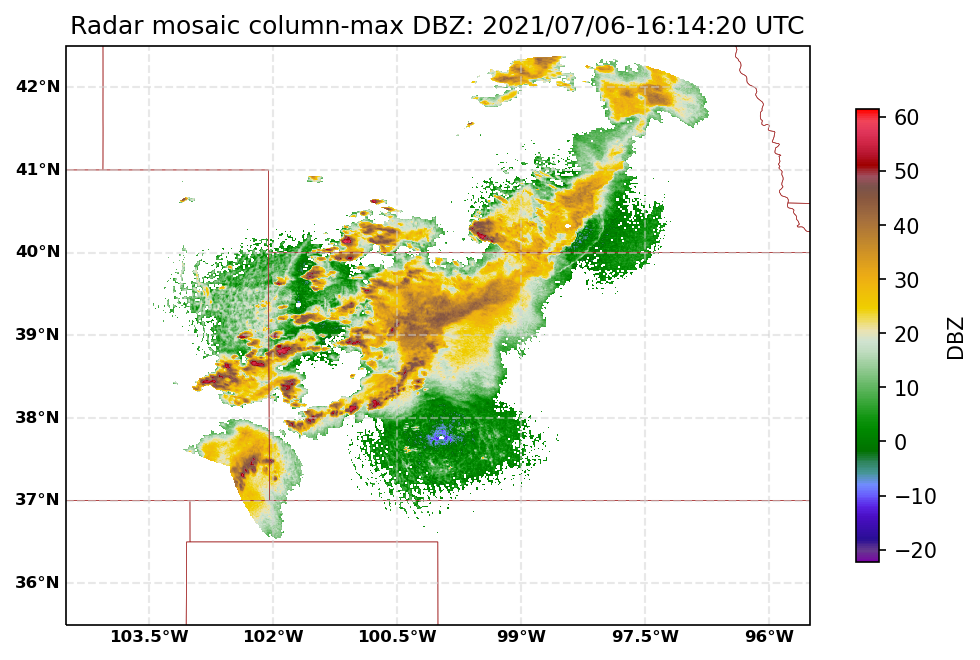

In [25]:
# Plot column-max reflectivity
figDbzComp = plt.figure(figsize=(8, 8), dpi=150)
axDbzComp = new_map(figDbzComp)
plt.imshow(dbzPlaneMax,
            cmap='pyart_Carbone42',
            interpolation = 'bilinear',
            origin = 'lower',
            extent = (minLonMosaic, maxLonMosaic, minLatMosaic, maxLatMosaic))
axDbzComp.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
axDbzComp.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='brown')
#axDbzComp.coastlines('10m', 'darkgray', linewidth=1, zorder=0)
plt.colorbar(label="DBZ", orientation="vertical", shrink=0.5)
plt.title("Radar mosaic column-max DBZ: " + startTimeStr)

In [26]:
# Compute W-E DBZ vertical section
nYHalfMosaic = int(nYMosaic/2)
dbzVertWE = dbz3D[:, nYHalfMosaic:(nYHalfMosaic+1), :]
dbzVertWE = dbzVertWE.reshape(dbzVertWE.shape[0], dbzVertWE.shape[2])
print('dbzVertWE.shape: ', dbzVertWE.shape)
dbzVertWE[dbzVertWE == fillValue] = np.nan
dbzVertWEMax = np.amax(dbz3D, axis=1)
dbzVertWEMax[dbzVertWEMax == fillValue] = np.nan
print('dbzVertWEMax.shape: ', dbzVertWEMax.shape)

# Compute DBZ N-S vertical section
nXHalfMosaic = int(nXMosaic/2)
dbzVertNS = dbz3D[:, :, nXHalfMosaic:(nXHalfMosaic+1)]
dbzVertNS = dbzVertNS.reshape(dbzVertNS.shape[0], dbzVertNS.shape[1])
dbzVertNS[dbzVertNS == fillValue] = np.nan
print('dbzVertNS.shape: ', dbzVertNS.shape)
dbzVertNSMax = np.amax(dbz3D, axis=2)
dbzVertNSMax[dbzVertNSMax == fillValue] = np.nan
print('dbzVertNSMax.shape: ', dbzVertNSMax.shape)


dbzVertWE.shape:  (31, 900)
dbzVertWEMax.shape:  (31, 900)
dbzVertNS.shape:  (31, 700)
dbzVertNSMax.shape:  (31, 700)


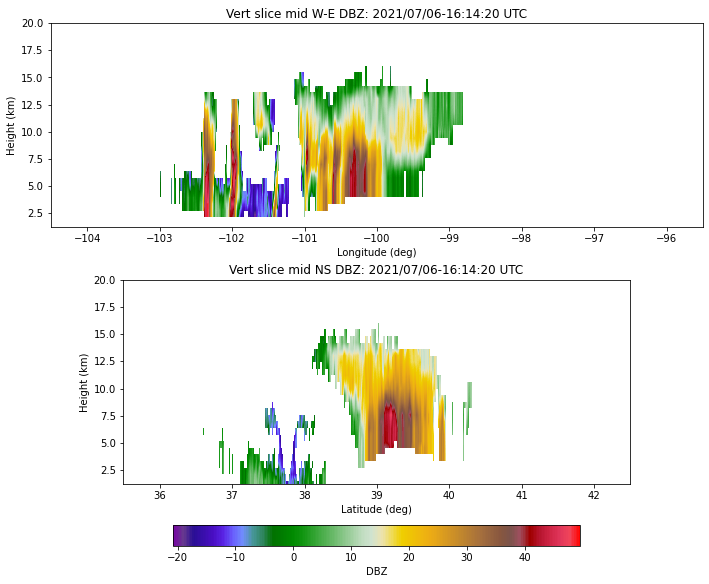

In [27]:
# Plot mid W-E DBZ vertical section

fig2 = plt.figure(num=2, figsize=[12, 8], layout='constrained')
ax2a = fig2.add_subplot(211, xlim = (minLonMosaic, maxLonMosaic), ylim = (minHtMosaic, maxHtMosaic))
plt.imshow(dbzVertWE,
    cmap='pyart_Carbone42',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonMosaic, maxLonMosaic, minHtMosaic, maxHtMosaic))
ax2a.set_aspect(0.15)
ax2a.set_xlabel('Longitude (deg)')
ax2a.set_ylabel('Height (km)')
plt.title("Vert slice mid W-E DBZ: " + startTimeStr)

# Plot mid N-S DBZ vertical section

ax2b = fig2.add_subplot(212, xlim = (minLatMosaic, maxLatMosaic), ylim = (minHtMosaic, maxHtMosaic))
plt.imshow(dbzVertNS,
    cmap='pyart_Carbone42',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatMosaic, maxLatMosaic, minHtMosaic, maxHtMosaic))
ax2b.set_aspect(0.15)
ax2b.set_xlabel('Latitude (deg)')
ax2b.set_ylabel('Height (km)')
plt.title("Vert slice mid NS DBZ: " + startTimeStr)

plt.colorbar(label="DBZ", orientation="horizontal", fraction=0.1)

### View the Ecco parameter file

The paths of the input files, and the output results file, are specified in the parameters.

Also included are all of the parameters used to control the algorithm.


In [28]:
# View the param file
!cat ./params/Ecco.nexrad_mosaic

/**********************************************************************
 * TDRP params for Ecco
 **********************************************************************/

//======================================================================
//
// Program name: Ecco.
//
// Ecco finds convective and stratiform regions within a Cartesian radar 
//   volume.
//
//======================================================================
 
//======================================================================
//
// PROCESS CONTROL.
//
//======================================================================
 
///////////// debug ///////////////////////////////////
//
// Debug option.
//
// If set, debug messages will be printed appropriately.
//
//
// Type: enum
// Options:
//     DEBUG_OFF
//     DEBUG_NORM
//     DEBUG_VERBOSE
//     DEBUG_EXTRA
//

debug = DEBUG_OFF;

///////////// instance ////////////////////////////////
//
// Process instance.
//
// Used for registration with procmap.


### Run Ecco

Ecco computes the convective/stratiform partition using radar reflectivity in Cartesian coordinates.

We run Ecco by specifying the parameter file, and the start and end times for the analysis.

In [29]:
# Run Ecco using param file
!/usr/local/lrose/bin/Ecco -params ./params/Ecco.nexrad_mosaic -debug -start "2021 07 06 22 00 00" -end "2021 07 06 22 30 00"

Program 'Ecco'
Run-time 2022/08/23 23:24:27.

Copyright (c) 1992 - 2022
University Corporation for Atmospheric Research (UCAR)
National Center for Atmospheric Research (NCAR)
Boulder, Colorado, USA.

Redistribution and use in source and binary forms, with
or without modification, are permitted provided that the following
conditions are met:

1) Redistributions of source code must retain the above copyright
notice, this list of conditions and the following disclaimer.

2) Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the
documentation and/or other materials provided with the distribution.

3) Neither the name of UCAR, NCAR nor the names of its contributors, if
any, may be used to endorse or promote products derived from this
software without specific prior written permission.

4) If the software is modified to produce derivative works, such modified
software should be clearly marked, so as not to confuse

### Read in Ecco results for a selected time

In [30]:
# Read in ecco results for a selected time
filePathEcco = os.path.join(nexradDataDir, 'mdv/ecco/mosaic/20210706/20210706_221500.mdv.cf.nc')
dsEcco = nc.Dataset(filePathEcco)
print(dsEcco)

# create 3D ecco type array with nans for missing vals

eccoField = dsEcco['EchoType3D']
ecco3D = np.array(eccoField)
fillValue = eccoField._FillValue
print("fillValue: ", fillValue)
print("ecco3D.shape: ", ecco3D.shape)

# if 4D (i.e. time is dim0) change to 3D
if (len(ecco3D.shape) == 4):
    ecco3D = ecco3D[0]

# Compute Ecco grid limits
(nZEcco, nYEcco, nXEcco) = ecco3D.shape
lon = np.array(dsEcco['x0'])
lat = np.array(dsEcco['y0'])
ht = np.array(dsEcco['z2'])
dLonEcco = lon[1] - lon[0]
dLatEcco = lat[1] - lat[0]
minLonEcco = lon[0] - dLonEcco / 2.0
maxLonEcco = lon[-1] + dLonEcco / 2.0
minLatEcco = lat[0] - dLatEcco / 2.0
maxLatEcco = lat[-1] + dLatEcco / 2.0
minHtEcco = ht[0]
maxHtEcco = ht[-1]
print("minLonEcco, maxLonEcco: ", minLonEcco, maxLonEcco)
print("minLatEcco, maxLatEcco: ", minLatEcco, maxLatEcco)
print("minHt, maxHt: ", minHtEcco, maxHtEcco)
print("ht: ", ht)
del lon, lat, ht

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    history: Converted from NetCDF to MDV, 2022/08/23 23:24:47
  Ncf:history: Data merged from following files:
  /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KGLD/20210706/ncf_20210706_221420.nc
  /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KUEX/20210706/ncf_20210706_221633.nc
  /tmp/lrose_data/nexrad_mosaic/mdv/radarCart/KDDC/20210706/ncf_20210706_221600.nc

  Ncf:comment: 
 : Stratfinder used to identify stratiform regions
    source: NEXRAD radars
    title: 3D RADAR MOSAIC
    comment: 
    dimensions(sizes): time(1), bounds(2), x0(900), y0(700), x1(139), y1(72), z0(1), z1(32), z2(31), nbytes_mdv_chunk_0000(485)
    variables(dimensions): float64 time(time), float64 start_time(time), float64 stop_time(time), float64 time_bounds(time, bounds), float32 x0(x0), float32 y0(y0), float32 x1(x1), float32 y1(y1), float32 z0(z0), float32 z1(z1), float32 z2(z2), int32 grid_mapping_0(

### Compute the column-max of the Ecco 3-D results 

In [31]:
# Compute column-max echo type
eccoPlaneMax = np.amax(ecco3D, (0))
eccoPlaneMax[eccoPlaneMax == fillValue] = np.nan
print(eccoPlaneMax.shape)
print(eccoPlaneMax[eccoPlaneMax != np.nan])
print(np.min(eccoPlaneMax[eccoPlaneMax != np.nan]))
print(np.max(eccoPlaneMax))

(700, 900)
[nan nan nan ... nan nan nan]
nan
nan


### Plot the column max of the Ecco results

Text(0.5, 1.0, 'Column max of Echo Type for radar mosaic: 2021/07/06-16:14:20 UTC')

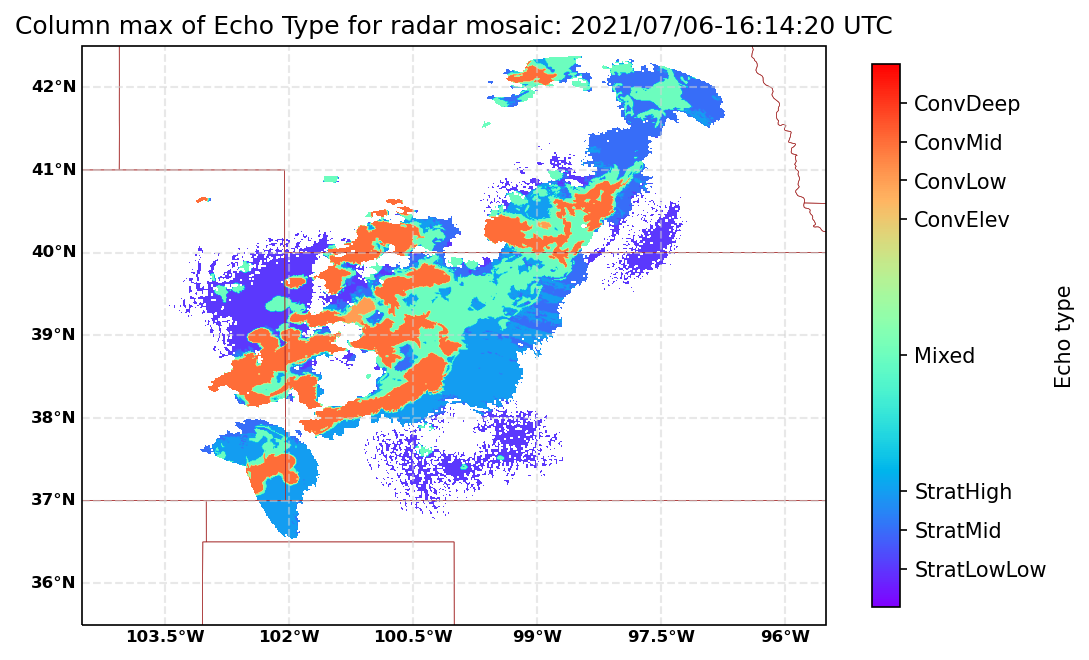

In [32]:
# Plot column-max ecco
figEcco = plt.figure(figsize=(8, 8), dpi=150)
axEcco = new_map(figEcco)
plt.imshow(eccoPlaneMax,
            cmap='rainbow', vmin=12, vmax=40,
            interpolation = 'bilinear',
            origin = 'lower',
            extent = (minLonEcco, maxLonEcco, minLatEcco, maxLatEcco))
axEcco.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black')
axEcco.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='brown')
cbarEcco = plt.colorbar(label="Echo type", cax=None, orientation="vertical", shrink=0.6)
cbarEcco.set_ticks([14,16,18,25,32,34,36,38],
                   labels=['StratLowLow', 'StratMid', 'StratHigh', 'Mixed',
                           'ConvElev', 'ConvLow', 'ConvMid', 'ConvDeep'])

plt.title("Column max of Echo Type for radar mosaic: " + startTimeStr)


## Plot vertical sections for Echo Type

In [33]:
# Compute W-E Ecco vertical section
nYHalfEcco = int(nYEcco/2)
eccoVertWE = ecco3D[:, nYHalfEcco:(nYHalfEcco+1), :]
eccoVertWE = eccoVertWE.reshape(eccoVertWE.shape[0], eccoVertWE.shape[2])
print('eccoVertWE.shape: ', eccoVertWE.shape)
eccoVertWE[eccoVertWE == fillValue] = np.nan
eccoVertWEMax = np.amax(ecco3D, axis=1)
eccoVertWEMax[eccoVertWEMax == fillValue] = np.nan
print('eccoVertWEMax.shape: ', eccoVertWEMax.shape)

# Compute ecco N-S vertical section
nXHalfEcco = int(nXEcco/2)
eccoVertNS = ecco3D[:, :, nXHalfEcco:(nXHalfEcco+1)]
eccoVertNS = eccoVertNS.reshape(eccoVertNS.shape[0], eccoVertNS.shape[1])
eccoVertNS[eccoVertNS == fillValue] = np.nan
print('eccoVertNS.shape: ', eccoVertNS.shape)
eccoVertNSMax = np.amax(ecco3D, axis=2)
eccoVertNSMax[eccoVertNSMax == fillValue] = np.nan
print('eccoVertNSMax.shape: ', eccoVertNSMax.shape)


eccoVertWE.shape:  (31, 900)
eccoVertWEMax.shape:  (31, 900)
eccoVertNS.shape:  (31, 700)
eccoVertNSMax.shape:  (31, 700)


Text(0.5, 1.0, 'Echo type vert slice mid NS: 2021/07/06-16:14:20 UTC')

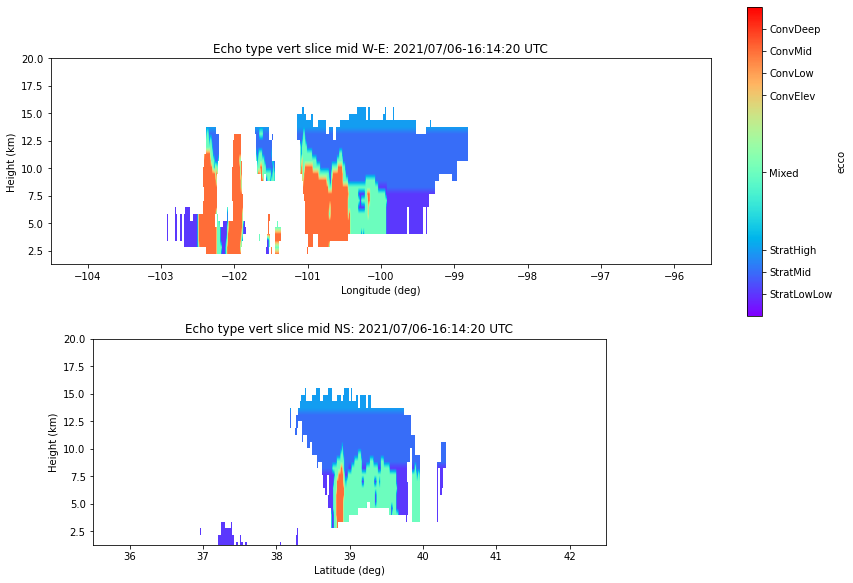

In [34]:
# Plot mid W-E ecco vertical section

figEccoVert = plt.figure(num=2, figsize=[12, 8], layout='constrained')
axEv1 = figEccoVert.add_subplot(211, xlim = (minLonEcco, maxLonEcco), ylim = (minHtEcco, maxHtEcco))
plt.imshow(eccoVertWE,
    vmin=12, vmax=40,
    cmap='rainbow',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLonEcco, maxLonEcco, minHtEcco, maxHtEcco))
axEv1.set_aspect(0.15)
axEv1.set_xlabel('Longitude (deg)')
axEv1.set_ylabel('Height (km)')
plt.title("Echo type vert slice mid W-E: " + startTimeStr)

cbar = plt.colorbar(label="ecco", cax=None, orientation="vertical", shrink=1.5)
cbar.set_ticks([14,16,18,25,32,34,36,38], labels=['StratLowLow', 'StratMid', 'StratHigh', 'Mixed', 'ConvElev', 'ConvLow', 'ConvMid', 'ConvDeep'])

# Plot mid N-S ecco vertical section

axEv2 = figEccoVert.add_subplot(212, xlim = (minLatEcco, maxLatEcco), ylim = (minHtEcco, maxHtEcco))
plt.imshow(eccoVertNS,
    vmin=12, vmax=40,
    cmap='rainbow',
    interpolation = 'bilinear',
    origin = 'lower',
    extent = (minLatEcco, maxLatEcco, minHtEcco, maxHtEcco))
axEv2.set_aspect(0.15)
axEv2.set_xlabel('Latitude (deg)')
axEv2.set_ylabel('Height (km)')
plt.title("Echo type vert slice mid NS: " + startTimeStr)
